In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
df = pd.read_csv('FSV.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-10,121.910004,122.669998,121.160004,122.220001,121.442528,16500
1,2022-10-11,120.830002,121.199997,118.400002,118.849998,118.093964,56400
2,2022-10-12,118.330002,119.940002,118.169998,119.279999,118.521233,36600
3,2022-10-13,116.870003,120.930000,114.800003,120.290001,119.524803,49300
4,2022-10-14,120.440002,121.589996,117.940002,118.580002,117.825684,33200


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.087965
1,0.006525
2,0.016916
3,0.041324
4,0.000000


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tqdm import tqdm

def forecast():
    model = Sequential()
    model.add(LSTM(size_layer, input_shape=(timestamp, df_log.shape[1]), return_sequences=True))
    model.add(LSTM(size_layer, return_sequences=True))
    model.add(Dense(df_log.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
          index = min(k + timestamp, df_train.shape[0] - 1)
          batch_x = np.zeros((1, 5, 1))
          batch_x[0, :index - k, 0] = df_train.iloc[k : index, :].values.reshape(-1)
          batch_y = np.zeros((1, 5, 1))
          batch_y[0, :index - k, 0] = df_train.iloc[k + 1 : index + 1, :].values.reshape(-1)
          loss = model.train_on_batch(batch_x, batch_y)
          total_loss.append(loss)
          pbar.set_postfix(cost=np.mean(total_loss))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0].values
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = model.predict(df_train.iloc[k : k + timestamp, :].values.reshape(1, timestamp, -1))
        output_predict[k + 1 : k + timestamp + 1] = out_logits[0]

    if upper_b != df_train.shape[0]:
        out_logits = model.predict(df_train.iloc[upper_b:, :].values.reshape(1, df_train.shape[0] - upper_b, -1))
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits[0]
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = out_logits[0]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = model.predict(o.reshape(1, timestamp, -1))
        # Almacena solo la última predicción en la posición adecuada
        output_predict[-future_day + i, 0] = out_logits[0, -1, 0]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [05:22<00:00,  1.07s/it, cost=0.00255]


1/1 [==============================] - 0s 25ms/step
simulation 2


train loop: 100%|██████████| 300/300 [05:19<00:00,  1.06s/it, cost=0.00256]


1/1 [==============================] - 0s 26ms/step
simulation 3


train loop: 100%|██████████| 300/300 [05:17<00:00,  1.06s/it, cost=0.00255]


1/1 [==============================] - 0s 23ms/step
simulation 4


train loop: 100%|██████████| 300/300 [05:19<00:00,  1.07s/it, cost=0.00256]


1/1 [==============================] - 0s 24ms/step
simulation 5


train loop: 100%|██████████| 300/300 [05:24<00:00,  1.08s/it, cost=0.00256]


1/1 [==============================] - 0s 24ms/step
simulation 6


train loop: 100%|██████████| 300/300 [05:20<00:00,  1.07s/it, cost=0.00257]


1/1 [==============================] - 0s 40ms/step
simulation 7


train loop: 100%|██████████| 300/300 [05:22<00:00,  1.08s/it, cost=0.00255]


1/1 [==============================] - 0s 32ms/step
simulation 8


train loop: 100%|██████████| 300/300 [05:24<00:00,  1.08s/it, cost=0.00256]


1/1 [==============================] - 0s 23ms/step
simulation 9


train loop: 100%|██████████| 300/300 [05:15<00:00,  1.05s/it, cost=0.00258]


1/1 [==============================] - 0s 25ms/step
simulation 10


train loop: 100%|██████████| 300/300 [05:14<00:00,  1.05s/it, cost=0.00259]


1/1 [==============================] - 0s 36ms/step


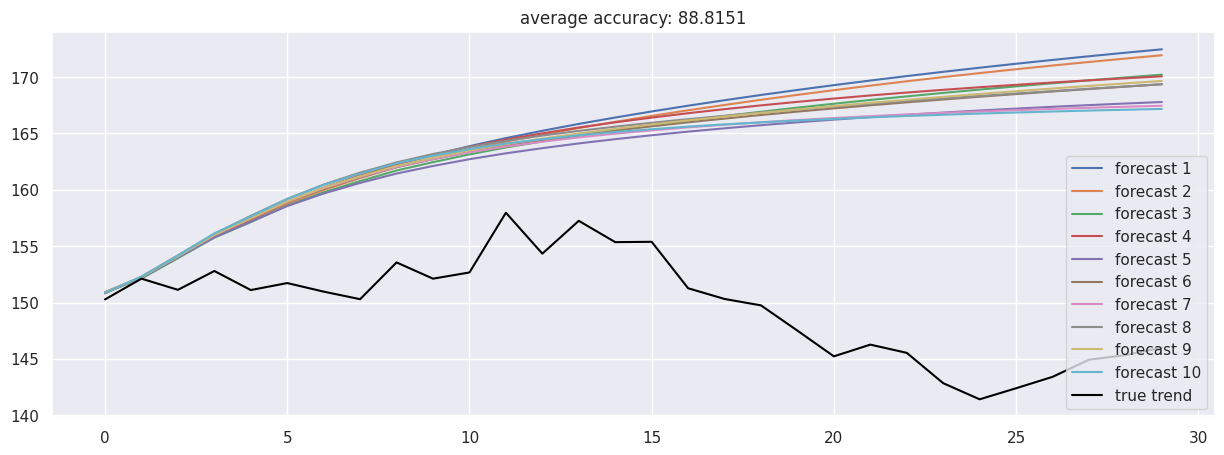

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()